In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
df = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')

In [4]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
df.shape

(50000, 2)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [7]:
df = df.reset_index(drop=False)

df = df.rename(columns={'index': 'Id'})

# **VADER Seniment Scoring**

In [8]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [9]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['review']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/50000 [00:00<?, ?it/s]

In [10]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [11]:
vaders.head()

,Id,neg,neu,pos,compound,review,sentiment
0,0,0.203,0.748,0.048,-0.9951,One of the other reviewers has mentioned that ...,positive
1,1,0.053,0.776,0.172,0.9641,A wonderful little production. <br /><br />The...,positive
2,2,0.094,0.714,0.192,0.9605,I thought this was a wonderful way to spend ti...,positive
3,3,0.138,0.797,0.065,-0.9213,Basically there's a family where a little boy ...,negative
4,4,0.052,0.801,0.147,0.9744,"Petter Mattei's ""Love in the Time of Money"" is...",positive


# **Plot VADER results**

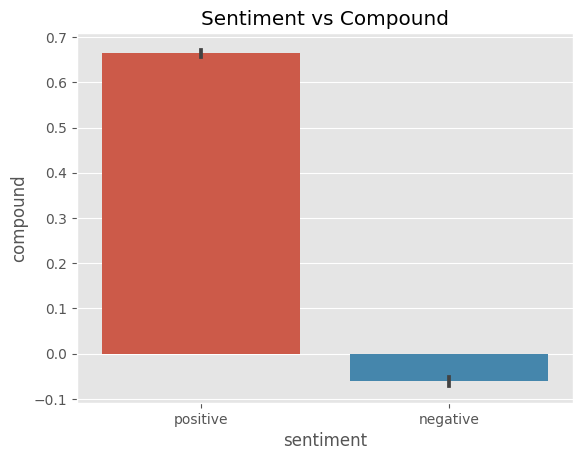

In [12]:
ax = sns.barplot(data=vaders, x='sentiment', y='compound')
ax.set_title('Sentiment vs Compound')
plt.show()

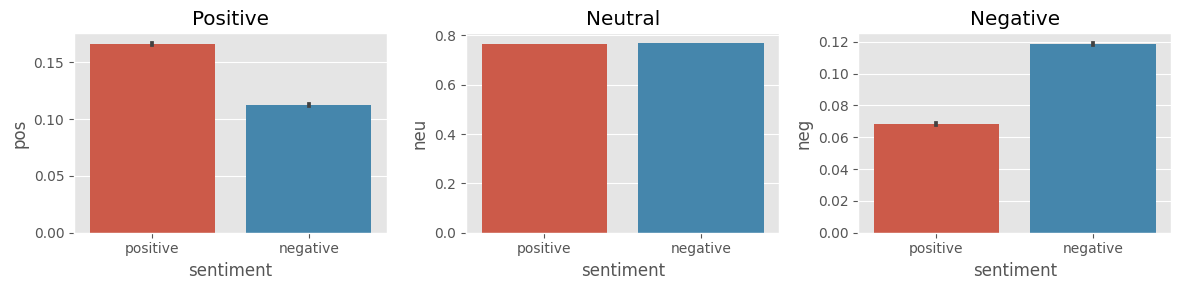

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='sentiment', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='sentiment', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='sentiment', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# **BERT Model**

In [14]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests

In [15]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [16]:
def sentiment_score(review):
    tokens = tokenizer.encode(review, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1

In [17]:
df['score'] = df['review'].apply(lambda x: sentiment_score(x[:512]))

In [18]:
df.head()

,Id,review,sentiment,score
0,0,One of the other reviewers has mentioned that ...,positive,2
1,1,A wonderful little production. <br /><br />The...,positive,5
2,2,I thought this was a wonderful way to spend ti...,positive,4
3,3,Basically there's a family where a little boy ...,negative,3
4,4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,4


# **Plot BERT Result**

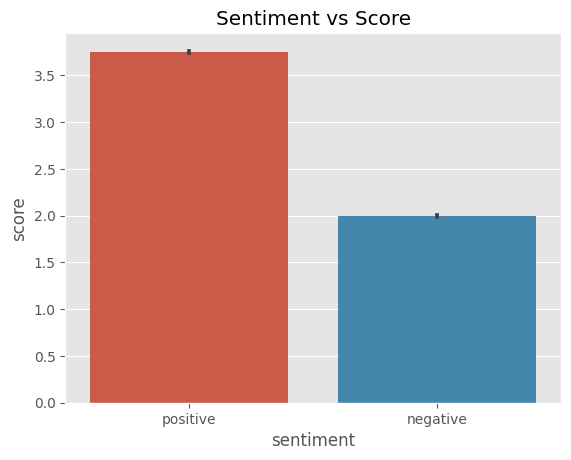

In [19]:
ax = sns.barplot(data=df, x='sentiment', y='score')
ax.set_title('Sentiment vs Score')
plt.show()